In [1]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)



import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
from modules.utils import load_runs_final_artifact
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *


DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

DEVICE cpu


In [2]:
# Set plotting variables

plt.rcParams.update({
    'font.size': 8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'],
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'lines.linewidth': 1.0,
    'lines.markersize': 4,
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'axes.linewidth': 0.8, 
})

c_tcn = '#0072B2'
c_mp = '#D55E00'


In [3]:
models = {
    "48mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "avid-sweep-24",
        'encoder_decoder_tcn': "blank",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank'
    },
        "60mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-9.2MHz_2.775.V_0.129A_60ma_scale2_dynamic_power_0.5-3.zarr", DEVICE),
        'tcn_channel': "snowy-sweep-4",
        'encoder_decoder_tcn': "blank",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank'
    }
}




Loaded from cache!


c:\Users\maild\mldrivenpeled\modules\utils.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!


In [4]:

# Iterate over different current levels and fit memory polynomial models
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    mp_model = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=torch.device('cpu'))
    _, _ , _ = mp_model.fit(ofdm_info.sent_frames_time, ofdm_info.received_frames_time)
    model_info['memory_polynomial'] = mp_model

Loading from ../models\channel_models\avid-sweep-24\channel_model_final.pth
Loading from ../models\channel_models\snowy-sweep-4\channel_model_final.pth


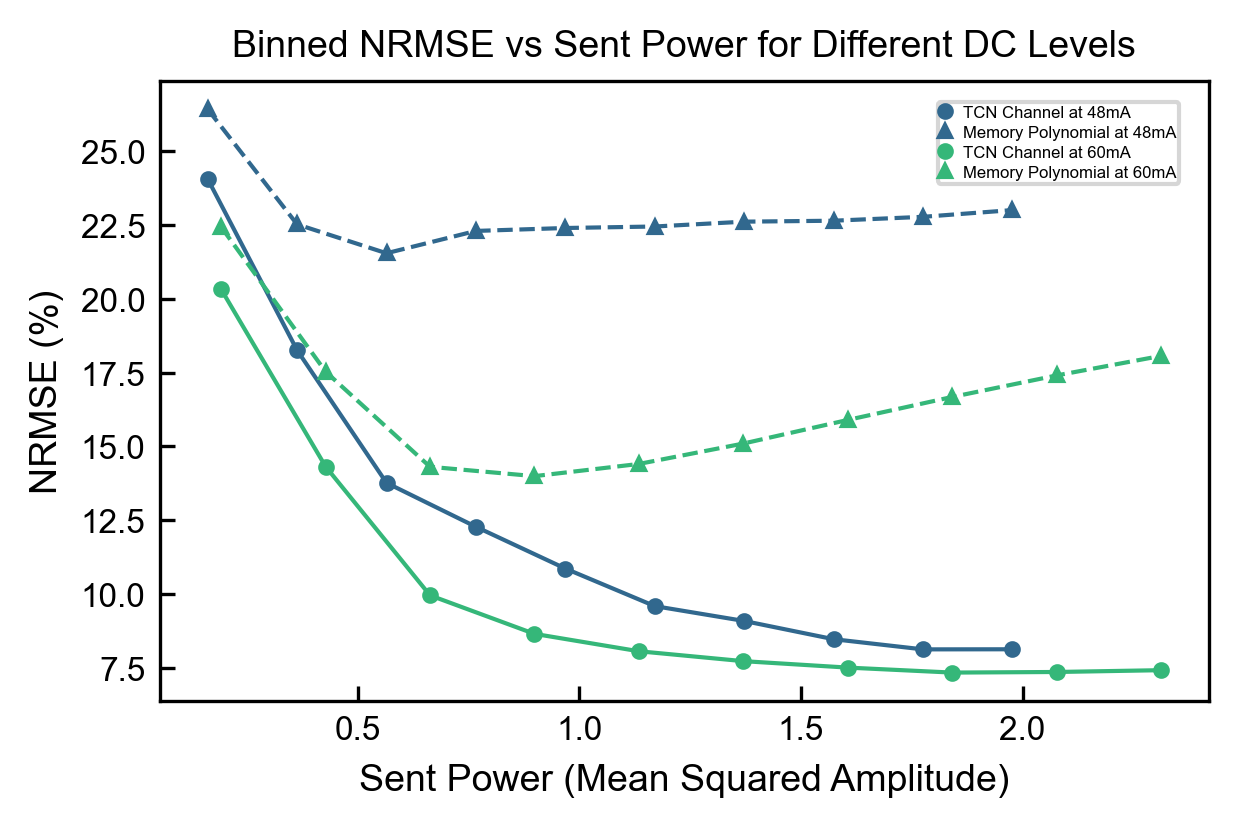

In [23]:
# G2 Plot

# Create scale of colors for different current levels
current_levels = list(models.keys())
num_levels = len(current_levels)
color_palette = sns.color_palette("viridis", num_levels)

    # Make one large figure with binned NRMSE for each current level
plt.figure(figsize=(4, 2.8))
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    Y = ofdm_info.received_frames_time.to(DEVICE)
    mp_model = model_info['memory_polynomial']
    tcn_model, tcn_cfg = load_runs_final_artifact(model_info['tcn_channel'], DEVICE, model_type='channel')



    # Divide into N power bins and compare NRMSE
    N = 10
    sent_powers = X.square().mean(dim=-1)
    pwr_min = sent_powers.min()
    pwr_max = sent_powers.max()

    bins = torch.linspace(pwr_min, pwr_max, N + 1)
    bin_ids = torch.bucketize(sent_powers, bins)
    binned_losses = torch.zeros(N, 2)
    for i in range(N):
        mask = bin_ids == i
        if mask.any():
            filtered_x = X[mask]
            filtered_y = Y[mask]
            noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn_model(filtered_x)
            tcn_rmse_loss = calculate_rmse_pct_loss(filtered_y, y_pred_tcn)
            mp_y_pred = mp_model(filtered_x)
            mp_rmse_loss = calculate_rmse_pct_loss(filtered_y, mp_y_pred)
            binned_losses[i, 0] = tcn_rmse_loss
            binned_losses[i, 1] = mp_rmse_loss
        else:
            binned_losses[i, 0] = torch.nan
            binned_losses[i, 1] = torch.nan

    # Plot binned losses
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers.cpu(), binned_losses[:, 0].cpu(), color=color_palette[current_levels.index(current_level)], marker='o', markersize=3, linestyle='-', label=f'TCN Channel at {current_level}')
    plt.plot(bin_centers.cpu(), binned_losses[:, 1].cpu(), color=color_palette[current_levels.index(current_level)], marker='^', markersize=3, linestyle='--', label=f'Memory Polynomial at {current_level}')           

plt.title("Binned NRMSE vs Sent Power for Different DC Levels")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.legend(
    fontsize=4,
    handlelength=0.5,
    labelspacing=0.3,
    borderpad=0.2,
    loc="best",
    bbox_to_anchor=(0.98, 0.98)
)
plt.tight_layout()
plt.ylabel("NRMSE (%)")
plt.show()        


In [7]:
# Analyze Experimental Validation Data
validations = {
    "dazzling-leaf-8110": {
        "encoder_decoder": "scarlet-spaceship-8109"
    }
}

root_val_path = os.path.abs(os.path.join(project_root, "data/validation_measurements"))
for val in validations.keys():
    data_path = os.path.join(root_val_path, f"{val}.zarr")
    data = extract_zarr_data(data_path, device=torch.device('cpu'))


AttributeError: module 'ntpath' has no attribute 'abs'